In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from __future__ import print_function

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import glob
import sys
import os
import re

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

os.makedirs('../../models',exist_ok=True)
np.set_printoptions(precision=3, linewidth=120)

Using TensorFlow backend.


In [2]:
import keras.backend as K

# K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, model_name, X_train, y_train, Xval=None, yval=None, 
                  opt='rmsprop', batch_size=60, nepochs=50000, patience=500, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2
        
    if Xval is not None:
        val_data = (Xval, yval)
    else:
        val_data = None

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=val_data, callbacks=[cb])
    except KeyboardInterrupt:
        pass

    return model, cb


def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))


In [4]:
data_dir = '../../datasets/'

def get_paragraphs(text):
    txt = re.sub('\n\n+', '\07', text)
    txt = re.sub('\n', ' ', txt)
    # txt = re.sub('  +', ' ', txt)
    txt = re.sub('\07CAPÍTULO [^\07]*\07', '\n', txt)
    return txt.split('\07')

book_texts = []
book_titles = []
char_count = 0
for fn in glob.glob(data_dir + 'livros/Machado_de_Assis__*.txt'):
    _, book = os.path.basename(fn).split('__')
    txt = open(fn, encoding='utf-8').read()
    par_list = get_paragraphs(txt)
    book_texts.append(par_list)
    book_titles.append(book[:-4])
    print('{:7d}  {}'.format(len(txt), book[:-4]))
    char_count += len(txt)
print('{:7d}'.format(char_count))

nb_books = len(book_texts)
nb_paras = [len(p) for p in book_texts]

 353713  Memorias_Postumas_de_Bras_Cubas
 281167  Memorial_de_Aires
 411870  Esau_e_Jaco
 373300  Dom_Casmurro
 336677  Iaia_Garcia
 445193  Quincas_Borba
 337533  Helena
2539453


In [5]:
all_text = ''
for paragraphs in book_texts:
    for para in paragraphs:
        all_text += para
    
chars = sorted(list(set(all_text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

nb_chars = len(chars)

print('\ntotal chars:', nb_chars)
print(chars)



total chars: 120
['\n', ' ', '!', '"', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '\x92', '\x93', '\x94', '\x96', '\x97', '\xa0', '¡', 'ª', '°', 'º', 'À', 'Á', 'Â', 'Ã', 'Ç', 'É', 'Ê', 'Í', 'Ó', 'Ô', 'Õ', 'Ú', 'à', 'á', 'â', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ô', 'õ', 'ú', 'ü']


In [6]:
def print_char_neighbours(ch):
    print('-'*60, '<{}> {:0x}'.format(ch, ord(ch)))
    i = all_text.find(ch)
    print(all_text[i-30:i], '<', ch, '>', all_text[i+1:i+30])

i = print_char_neighbours('ñ')
i = print_char_neighbours('\x92')
i = print_char_neighbours('\x93')
i = print_char_neighbours('\x94')
i = print_char_neighbours('\x96')
i = print_char_neighbours('\x97')
i = print_char_neighbours('\xa0')


------------------------------------------------------------ <ñ> f1
apenas doze anos.Cosas de Espa < ñ > a. Quem quer que fosse, porém
------------------------------------------------------------ <> 92
 sacristão, rezas, aspersões d <  > água benta, o fechar do caixã
------------------------------------------------------------ <> 93
eriu à beira de minha cova:   <  > Vós, que o conhecestes, meus 
------------------------------------------------------------ <> 94
ouvor ao nosso ilustre finado. <  > Bom e fiel amigo! Não, não me
------------------------------------------------------------ <> 96
 sempre as nossas moções.
Fez  <  > se o passeio à Tijuca, sem ou
------------------------------------------------------------ <> 97
 anúncios. Acresce que chovia  <  >  peneirava uma chuvinha miúda
------------------------------------------------------------ < > a0
ei de gostá,Lelê, coco, naiá.
 <   > MELHOR DE DESCER QUE DE SUBIR


In [7]:
seq_len = 40
step = 3
sentences = []
next_chars = []
indexes = []
for k, book_paragraphs in enumerate(book_texts):
    for j, text in enumerate(book_paragraphs):
        for i in range(0, len(text) - seq_len - 1, step):
            sentences.append(text[i: i + seq_len])
            next_chars.append(text[i + seq_len])
            indexes.append([k, j, i])

print('nb sequences:', len(sentences))

nb sequences: 726390


In [8]:
print('Vectorization ...')
nb_samples = len(sentences)

X = np.zeros((nb_samples, seq_len, nb_chars), dtype=np.bool)
y = np.zeros((nb_samples, nb_chars), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
print('X.shape:', X.shape)
print('y.shape:', y.shape)


Vectorization ...
X.shape: (726390, 40, 120)
y.shape: (726390, 120)


In [9]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(seq_len, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.summary()

# optimizer = RMSprop(lr=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=optimizer)


Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               127488    
_________________________________________________________________
dense_1 (Dense)              (None, 120)               15480     
_________________________________________________________________
activation_1 (Activation)    (None, 120)               0         
Total params: 142,968
Trainable params: 142,968
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split

X_tra, X_val, y_tra, y_val = train_test_split(X, y, test_size=0.5)
print(X_tra.shape, y_tra.shape, X_val.shape, y_val.shape)

(363195, 40, 120) (363195, 120) (363195, 40, 120) (363195, 120)


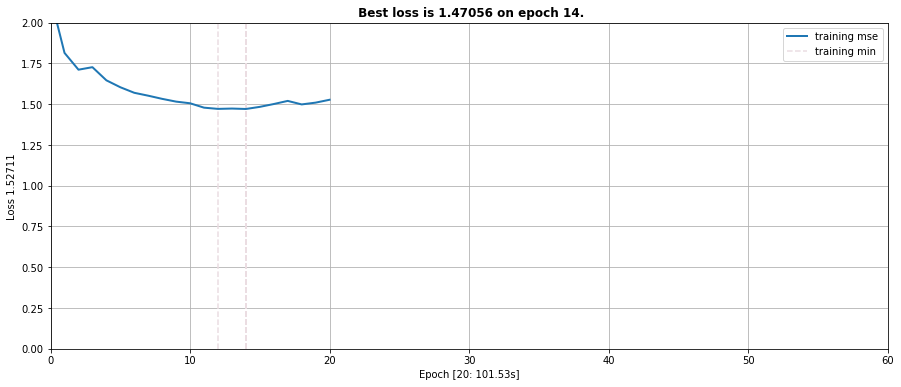

In [ ]:
model_name = '../../models/machado_1'

fit_params = {
    'opt':        RMSprop(lr=0.01),
    'batch_size': 128, 
    'nepochs':    60,
    'patience':   15,
    'ploss':      2.,
    'reset':      False,
}

N = 100000
Xtra, ytra = X_tra[:N], y_tra[:N]

train_network(model, model_name, Xtra, ytra, **fit_params);

In [19]:
model, histo = load_model_and_history(model_name)

In [20]:
start_index = random.randint(0, len(all_text) - seq_len - 1)
generated = ''
sentence = all_text[start_index: start_index + seq_len]
generated += sentence
print(sentence)
print('-'*len(sentence))

for i in range(400):
    x = np.zeros((1, seq_len, nb_chars))
    for t, char in enumerate(sentence):
        x[0, t, char_indices[char]] = 1.

    preds = model.predict(x, verbose=0)[0]
    index = np.argmax(preds)
    next_char = indices_char[index]
    
    generated += next_char
    sentence = sentence[1:] + next_char

    if i%100 == 0:
        print(generated)
        print('-'*60)
    

 Prudêncio,  o que meu pai libertara al
----------------------------------------
 Prudêncio,  o que meu pai libertara alg
------------------------------------------------------------
 Prudêncio,  o que meu pai libertara alguma coisa de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma ca
------------------------------------------------------------
 Prudêncio,  o que meu pai libertara alguma coisa de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma 
------------------------------------------------------------
 Prudêncio,  o que meu pai libertara alguma coisa de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma casa de pouco de propedia a mesma 